In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import os
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

from core.final.dataset import PSMDataset

In [3]:
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']

METADATA_COLS = [
    'mean_vmag',  'phot_g_mean_mag', 'e_phot_g_mean_mag', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe', 'l', 'b'
]

PHOTO_COLS = ['amplitude', 'period', 'lksl_statistic', 'rfr_score']

METADATA_FUNC = {
    "abs": [
        "mean_vmag",
        "phot_g_mean_mag",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "j_mag",
        "h_mag",
        "k_mag",
        "w1_mag",
        "w2_mag",
        "w3_mag",
        "w4_mag",
    ],
    "cos": ["l"],
    "sin": ["b"],
    "log": ["period"]
}

In [6]:
def get_config():
    config = {
        'project': 'AstroCLIPResults',
        'mode': 'meta',    # 'clip' 'photo' 'spectra' 'meta' 'all'
        'config_from': None,    # 'meridk/AstroCLIPResults/zgfcm56p',
        'random_seed': 42,  # 42, 66, 0, 12, 123
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        # 'use_pretrain': 'CLIP/home/mariia/AstroML/weights/2024-08-14-14-05-zmjau1cu/weights-51.pth',
        'use_pretrain': None,
        'freeze': False,

        # Data General
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full_lb/spectra_and_v',
        'classes': None,
        'num_classes': None,
        'meta_cols': METADATA_COLS,
        'photo_cols': PHOTO_COLS,
        'min_samples': None,
        'max_samples': None,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': False,
        'p_aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        's_mad': True,
        's_aux': True,
        's_err': True,
        's_err_norm': True,

        # Photometry Model
        'p_enc_in': 3,
        'p_d_model': 128,
        'p_dropout': 0.2,
        'p_factor': 1,
        'p_output_attention': False,
        'p_n_heads': 4,
        'p_d_ff': 512,
        'p_activation': 'gelu',
        'p_e_layers': 8,

        # Spectra Model
        's_dropout': 0.2,
        's_conv_channels': [1, 64, 64, 32, 32],
        's_kernel_size': 3,
        's_mp_kernel_size': 4,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0.2,

        # MultiModal Model
        'hidden_dim': 512,
        'fusion': 'avg',  # 'avg', 'concat'

        # Training
        'batch_size': 512,
        'lr': 0.001,
        'beta1': 0.9,
        'beta2': 0.999,
        'weight_decay': 0.01,
        'epochs': 100,
        'early_stopping_patience': 6,
        'scheduler': 'ReduceLROnPlateau',  # 'ExponentialLR', 'ReduceLROnPlateau'
        'gamma': 0.9,  # for ExponentialLR scheduler
        'factor': 0.3,  # for ReduceLROnPlateau scheduler
        'patience': 3,  # for ReduceLROnPlateau scheduler
        'warmup': True,
        'warmup_epochs': 10,
        'clip_grad': True,
        'clip_value': 45
    }

    if config['p_aux']:
        config['p_enc_in'] += len(config['photo_cols']) + 2     # +2 for mad and delta t

    if config['s_aux']:
        config['s_conv_channels'][0] += 1

    if config['s_err']:
        config['s_conv_channels'][0] += 1

    if config['config_from']:
        print(f"Copying params from the {config['config_from']} run")
        old_config = wandb.Api().run(config['config_from']).config

        for el in old_config:
            if el in [
                'p_dropout', 's_dropout', 'm_dropout', 'lr', 'beta1', 'weight_decay', 'epochs',
                'early_stopping_patience', 'factor', 'patience', 'warmup', 'warmup_epochs', 'clip_grad', 'clip_value',
                'use_pretrain', 'freeze', 'phased', 'p_aux', 'p_enc_in', 's_aux', 's_err', 's_conv_channels'
            ]:
                config[el] = old_config[el]

    return config

In [7]:
config = get_config()
train_dataset = PSMDataset(config, split='train')

In [50]:
inds = []

for i in tqdm(range(len(train_dataset))):
    el = train_dataset.df.iloc[i]
    p = train_dataset.get_vlc(el['name'])

    if (p[:, 2] > 10).any():
        inds.append(i)

100%|███████████████████████████████████████████████████████████████████████████| 17301/17301 [00:49<00:00, 352.02it/s]


In [51]:
inds

[1730, 7255, 7747, 7830, 7837, 7877, 7911, 13297, 15680, 16114, 16603]

<ErrorbarContainer object of 3 artists>

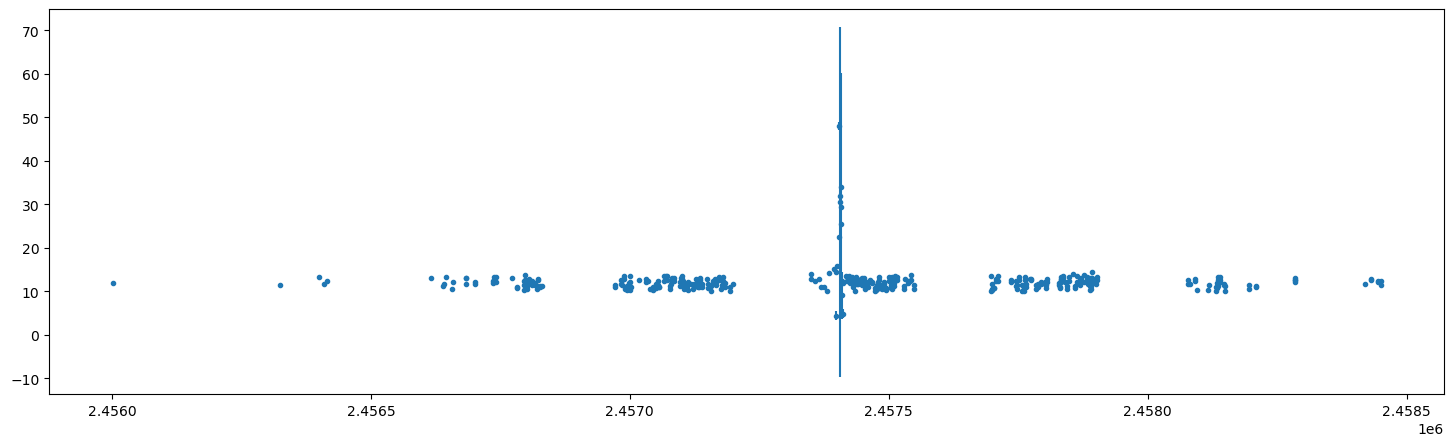

In [62]:
idx = 1730
el = train_dataset.df.iloc[idx]
p = train_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

In [63]:
mean = p[:, 1].mean()
std = p[:, 1].std()
mad = stats.median_abs_deviation(p[:, 1])
p[:, 1] = (p[:, 1] - mean) / mad
p[:, 2] = p[:, 2] / mad

<ErrorbarContainer object of 3 artists>

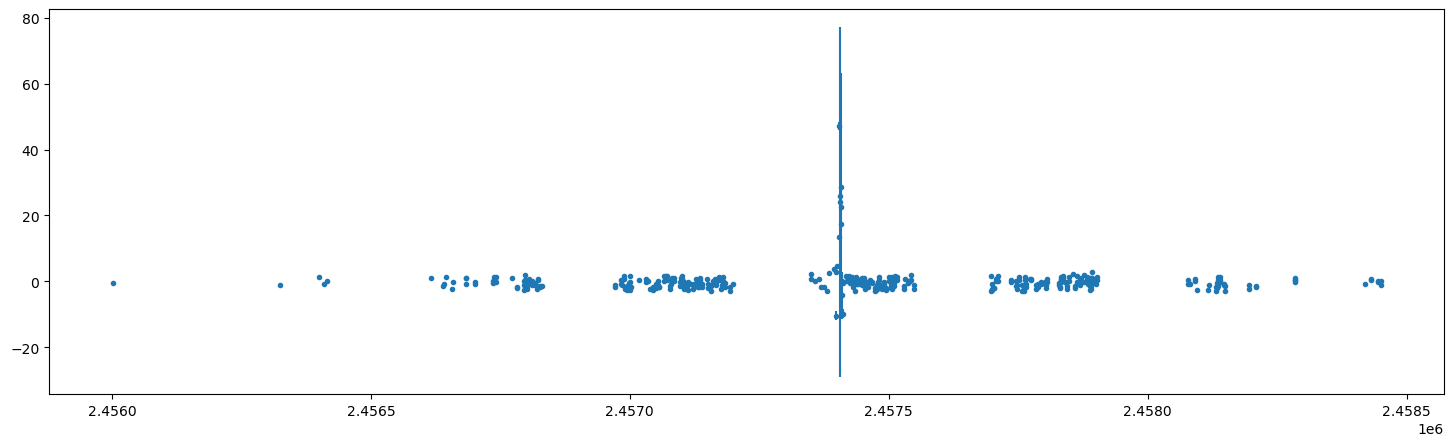

In [64]:
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

In [65]:
mad, std

(0.7584999999999997, 3.068497384168382)

<ErrorbarContainer object of 3 artists>

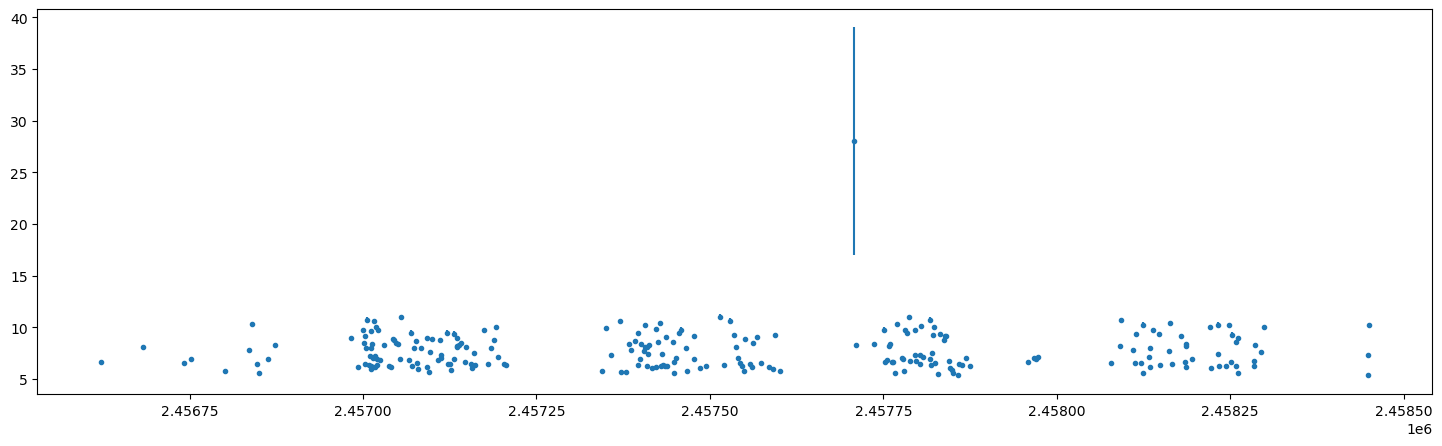

In [67]:
idx = 13297
el = train_dataset.df.iloc[idx]
p = train_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

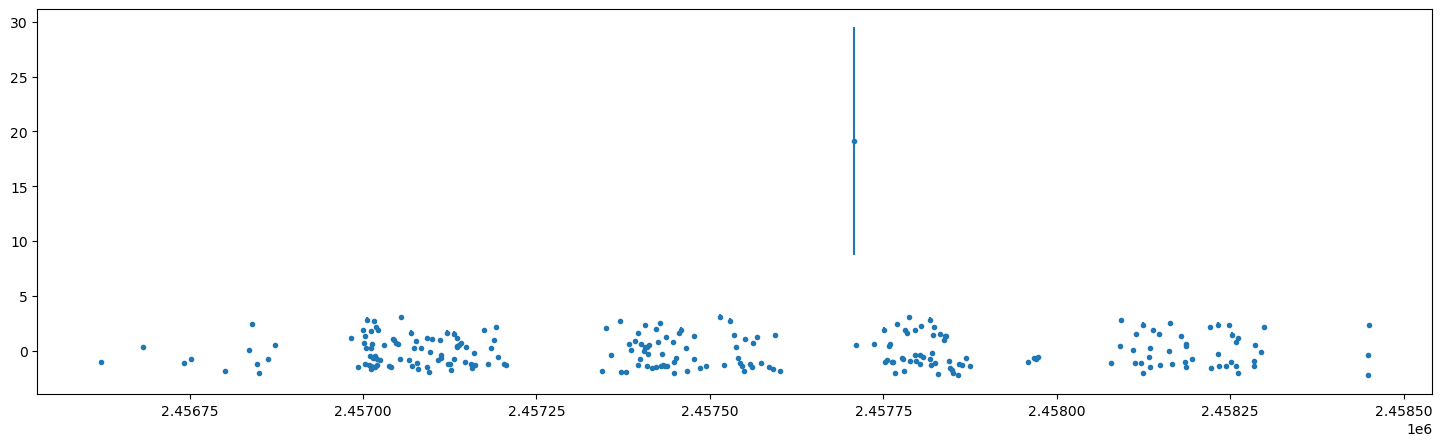

In [68]:
mean = p[:, 1].mean()
std = p[:, 1].std()
mad = stats.median_abs_deviation(p[:, 1])
p[:, 1] = (p[:, 1] - mean) / mad
p[:, 2] = p[:, 2] / mad

plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

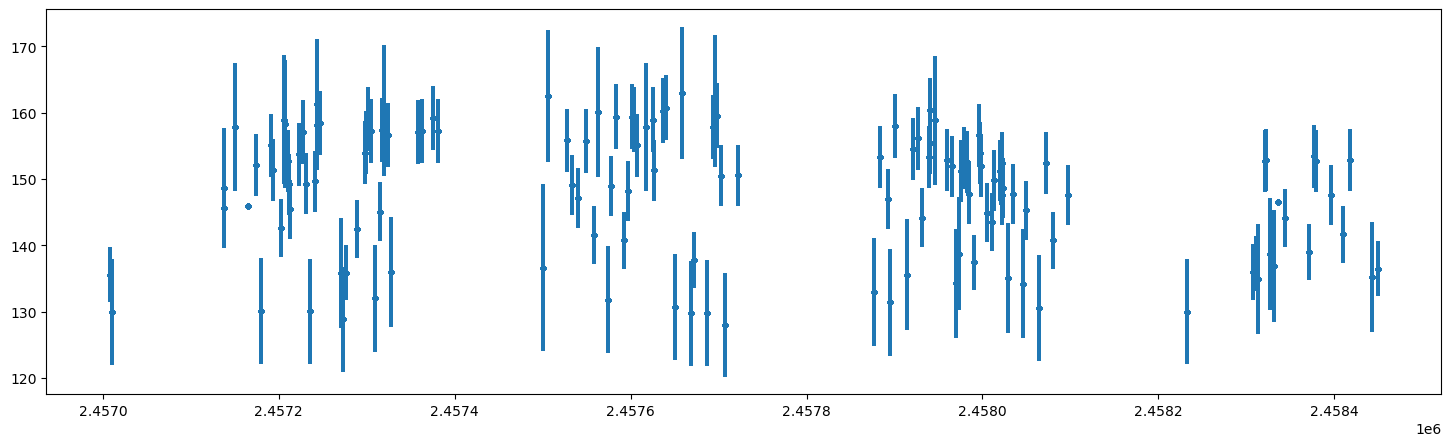

In [69]:
idx = 15680
el = train_dataset.df.iloc[idx]
p = train_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

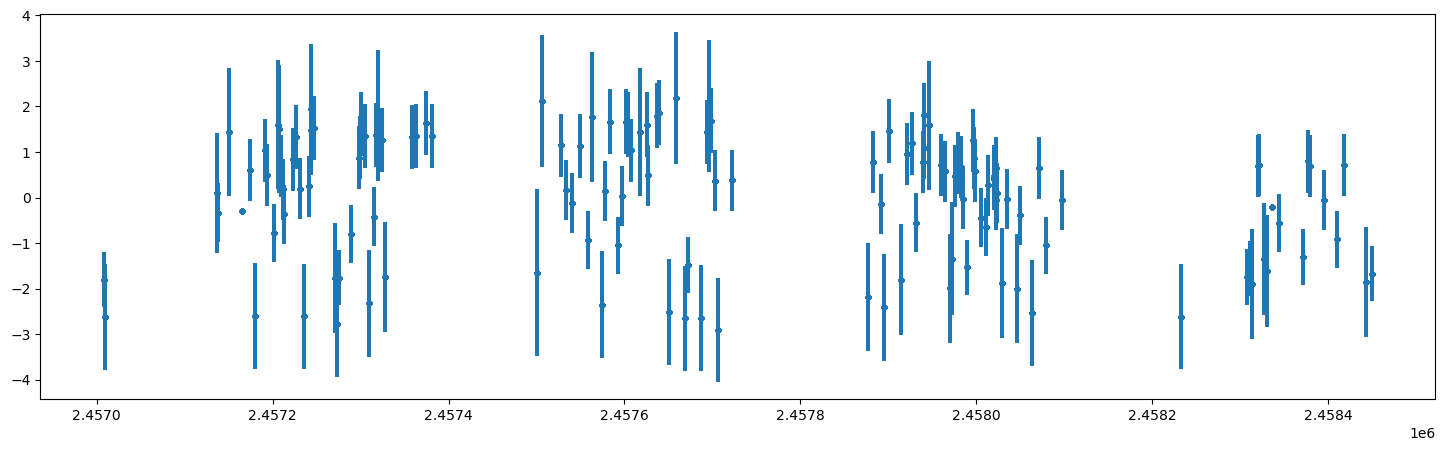

In [70]:
mean = p[:, 1].mean()
std = p[:, 1].std()
mad = stats.median_abs_deviation(p[:, 1])
p[:, 1] = (p[:, 1] - mean) / mad
p[:, 2] = p[:, 2] / mad

plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

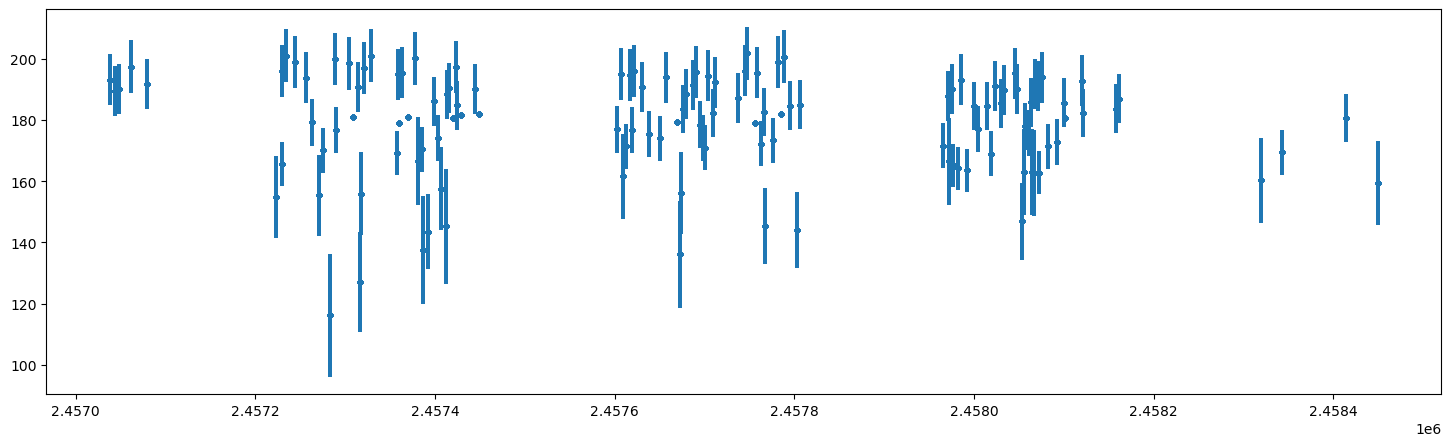

In [71]:
idx = 16114
el = train_dataset.df.iloc[idx]
p = train_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

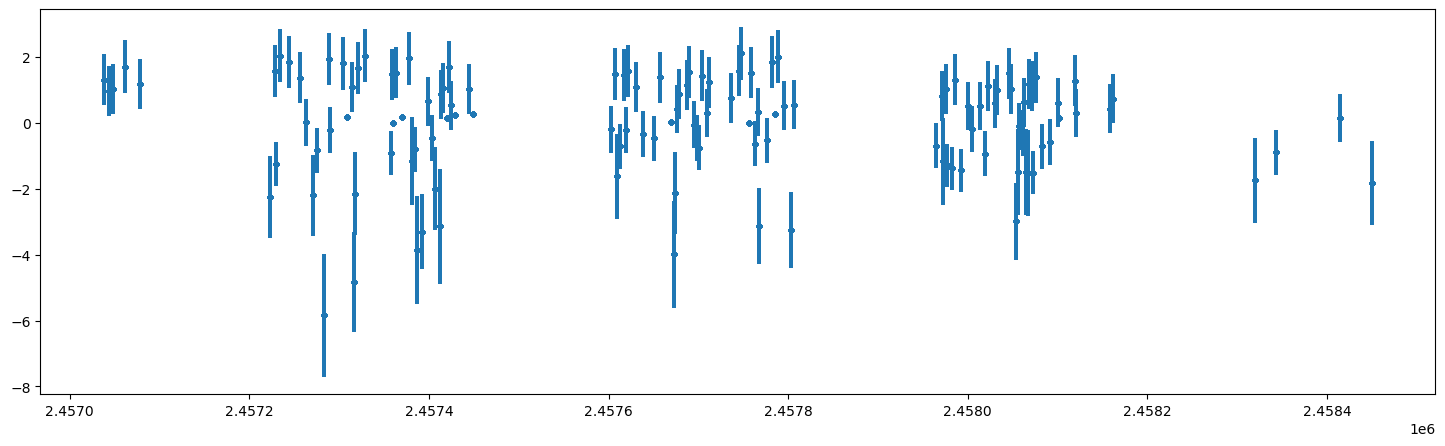

In [72]:
mean = p[:, 1].mean()
std = p[:, 1].std()
mad = stats.median_abs_deviation(p[:, 1])
p[:, 1] = (p[:, 1] - mean) / mad
p[:, 2] = p[:, 2] / mad

plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

In [73]:
val_dataset = PSMDataset(config, split='val')
inds = []

for i in tqdm(range(len(val_dataset))):
    el = val_dataset.df.iloc[i]
    p = val_dataset.get_vlc(el['name'])

    if (p[:, 2] > 10).any():
        inds.append(i)

100%|█████████████████████████████████████████████████████████████████████████████| 2184/2184 [00:07<00:00, 280.00it/s]


In [74]:
inds

[636, 974, 1867]

In [75]:
test_dataset = PSMDataset(config, split='test')
inds = []

for i in tqdm(range(len(test_dataset))):
    el = test_dataset.df.iloc[i]
    p = test_dataset.get_vlc(el['name'])

    if (p[:, 2] > 10).any():
        inds.append(i)

100%|█████████████████████████████████████████████████████████████████████████████| 2268/2268 [00:06<00:00, 356.99it/s]


In [76]:
inds

[615]

<ErrorbarContainer object of 3 artists>

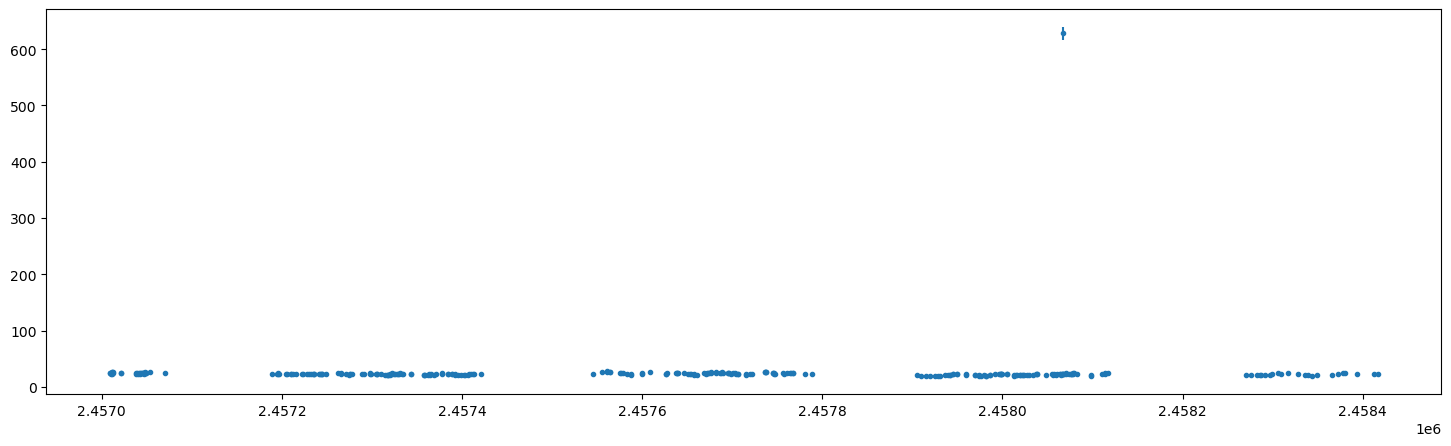

In [83]:
idx = 1867
el = val_dataset.df.iloc[idx]
p = val_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

In [85]:
el['target']

'SR'

<ErrorbarContainer object of 3 artists>

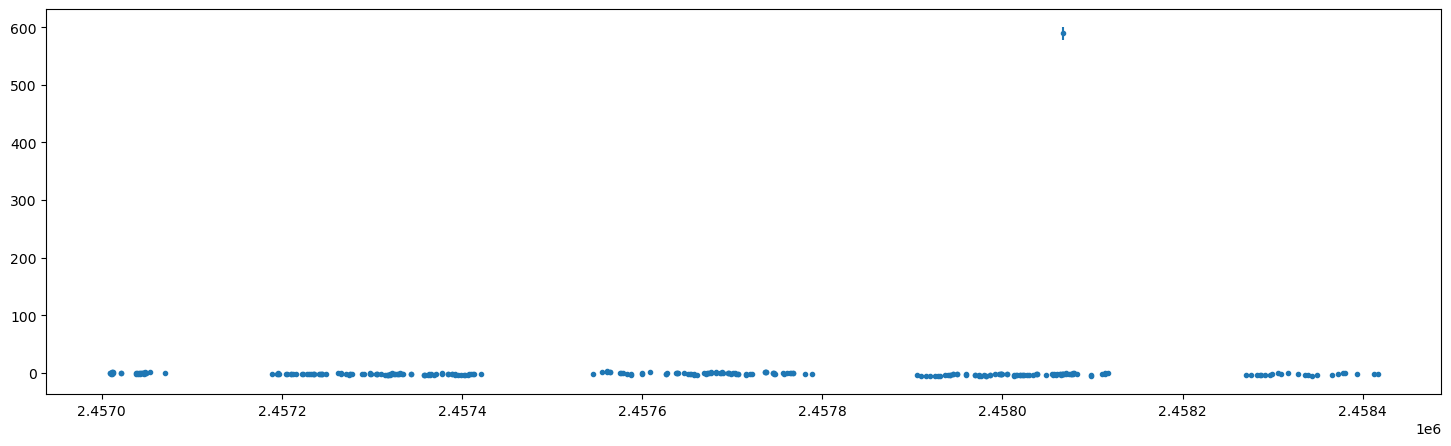

In [81]:
mean = p[:, 1].mean()
std = p[:, 1].std()
mad = stats.median_abs_deviation(p[:, 1])
p[:, 1] = (p[:, 1] - mean) / mad
p[:, 2] = p[:, 2] / mad

plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

<ErrorbarContainer object of 3 artists>

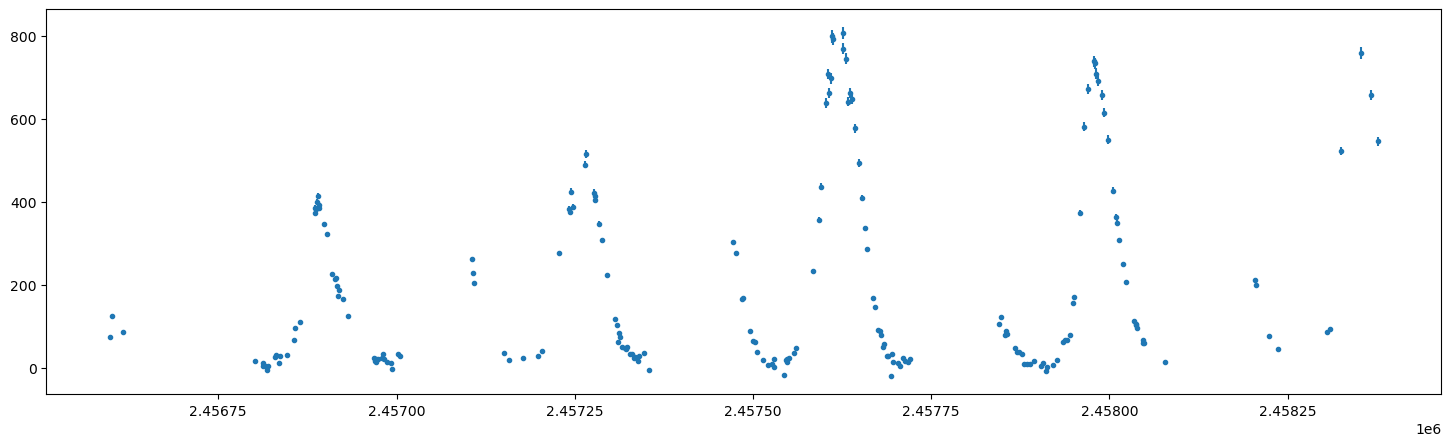

In [82]:
idx = 615
el = test_dataset.df.iloc[idx]
p = test_dataset.get_vlc(el['name'])
plt.figure(figsize=(18, 5))
plt.errorbar(p[:, 0], p[:, 1], yerr=p[:, 2], fmt='.')

### Remove 1730 and 13297 from train and 1867 from test

In [90]:
train_f = train_dataset.df.drop([1730, 13297])
test_f = test_dataset.df.drop([1867])

In [92]:
train_f.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train_norm.csv', index=False)
test_f.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test_norm.csv', index=False)

In [93]:
train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

train = train[train.index.isin(train_f.index)]
test = test[test.index.isin(test_f.index)]

train.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv', index=False)
test.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv', index=False)